### ATMS 523 Module 4 Project

Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2023 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The land sea mask is available here: https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc

Plot maps of the mean SST and mean total column water vapor for the entire period of record.

In [65]:
import xarray as xr

In [5]:
pip install dask

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [66]:
import dask

In [7]:
ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
                     chunks={'time':'500MB'})

variables = ['Total_column_water_vapour_surface_Mixed_intervals_Average',
        'Sea_surface_temperature_surface_Mixed_intervals_Average']
#select the two needed variables every 4th point to get 1 degree resolution
ds = ds[variables].sel(lat=slice(65, -65, 4), lon=slice(120, 300, 4))

In [67]:
ds

<xarray.Dataset> Size: 97MB
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 520B ...
  * lon                                                        (lon) float32 724B ...
  * time                                                       (time) datetime64[ns] 4kB ...
    reftime                                                    (time) datetime64[ns] 4kB ...
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 49MB ...
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 49MB ...
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [9]:
ds.to_netcdf('raw_data.nc')

In [10]:
pip install matplotlib cartopy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load the dataset (assuming ds is already your xarray.Dataset)
ds = xr.open_dataset('raw_data.nc')

In [68]:
ds

<xarray.Dataset> Size: 97MB
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 520B ...
  * lon                                                        (lon) float32 724B ...
  * time                                                       (time) datetime64[ns] 4kB ...
    reftime                                                    (time) datetime64[ns] 4kB ...
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 49MB ...
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 49MB ...
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [121]:
# Calculate the mean SST and mean TCWV over the entire period
mean_sst = ds['Sea_surface_temperature_surface_Mixed_intervals_Average'].mean(dim='time')
mean_tcwv = ds['Total_column_water_vapour_surface_Mixed_intervals_Average'].mean(dim='time')

In [70]:
mean_sst

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             lat: 130,
                                                                             lon: 181)> Size: 94kB
array([[      nan,       nan,       nan, ..., 272.62515, 272.71667,
        272.82245],
       [      nan,       nan,       nan, ..., 272.8599 , 273.0407 ,
        273.5661 ],
       [      nan,       nan,       nan, ..., 273.17636, 273.8434 ,
        274.68085],
       ...,
       [272.72824, 272.72784, 272.75504, ..., 272.98932, 272.9935 ,
        272.83612],
       [272.47736, 272.5224 , 272.54202, ..., 272.65787, 272.75925,
        272.2297 ],
       [272.1153 , 272.15176, 272.16583, ..., 272.13876, 271.73523,
              nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0

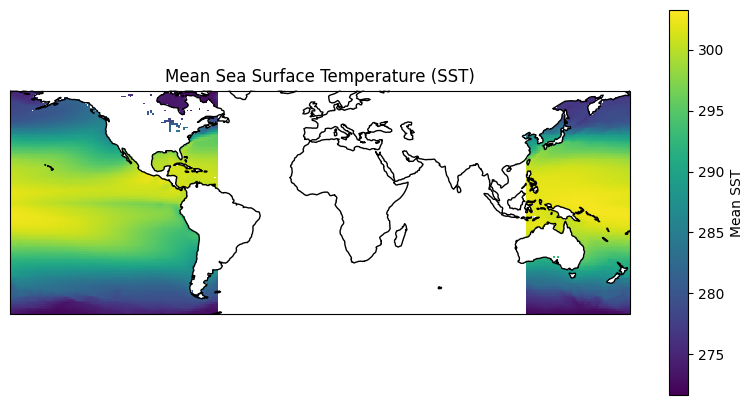

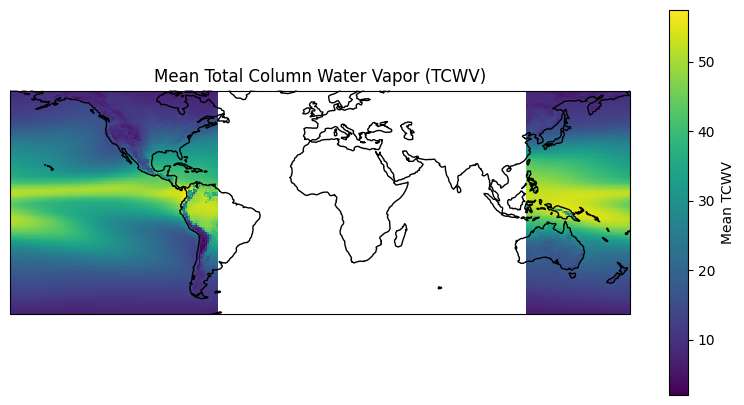

In [71]:
# Mean SST plot
fig1, ax1 = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax1.coastlines()  # Adds coastlines
mean_sst.plot(ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Mean SST'})
ax1.set_title('Mean Sea Surface Temperature (SST)')
plt.show()

# Mean TCWV plot
fig2, ax2 = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax2.coastlines()  # Adds coastlines
mean_tcwv.plot(ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Mean TCWV'})
ax2.set_title('Mean Total Column Water Vapor (TCWV)')
plt.show()

From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies. Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: 6.3. Preprocessing data — scikit-learn 1.1.2 documentation

In [72]:
#DESEASONING

import numpy as np

# Assuming 'sst' is the variable name for Sea Surface Temperature in your dataset
sst = ds['Sea_surface_temperature_surface_Mixed_intervals_Average']

climatology = sst.groupby('time.month').mean('time')
anomalies = sst.groupby('time.month') - climatology

In [73]:
#DETRENDING

# Defining the polynomial detrending function
def detrend_dim(da, dim, deg=1):
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# Applying a rolling mean to smooth the anomalies before detrending
smoothed_anomalies = anomalies.rolling(time=7, center=True).mean('time')

# Now, applying the polynomial detrending
detrended_anomalies = detrend_dim(smoothed_anomalies, 'time', 1)

In [74]:
# STANDARDIZING the anomalies
mean_anomalies = detrended_anomalies.mean('time', skipna=True)
std_anomalies = detrended_anomalies.std('time', skipna=True)
standardized_anomalies = (detrended_anomalies - mean_anomalies) / std_anomalies

# The standardized_anomalies xarray DataArray now contains the standardized SST anomalies


Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

In [75]:
# EOF CALCULATIONS
ystr = 1979 #starting year of data
yend = 2021 #ending year of data

# seasonal mean
anomalies_S = anomalies.rolling(time=3, center=True).mean('time')
anomalies_DJF=anomalies_S.sel(time=slice(f'{ystr}-02-01',f'{yend}-12-31',12))
print(anomalies_DJF)

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 43,
                                                                             lat: 130,
                                                                             lon: 181)> Size: 4MB
array([[[            nan,             nan,             nan, ...,
          2.03450527e-05, -2.07519531e-03, -1.30106611e-02],
        [            nan,             nan,             nan, ...,
         -1.94295251e-03, -6.64265966e-03,  2.27478027e-01],
        [            nan,             nan,             nan, ...,
          2.36409511e-02,  3.51643890e-01,  6.02325439e-01],
        ...,
        [-2.47253418e-01, -3.72589111e-01, -3.58632416e-01, ...,
         -6.01908386e-01, -4.34000641e-01, -2.98319489e-01],
        [-7.35961914e-01, -7.44252503e-01, -7.85044372e-01, ...,
         -5.33152282e-01, -3.14280182e-01,  1.06241859e-01],
       

In [76]:
# -- EOF calculations --
anomalies_DJF=detrend_dim(anomalies_DJF,'time',1)
anomalies_DJF = anomalies_DJF.sortby("lat", ascending=True)
clat = anomalies_DJF['lat'].astype(np.float64) 
clat = np.sqrt(np.cos(np.deg2rad(clat))) #Weight Calculation
#clat is the weight

In [77]:
# Checking if 'long_name' attribute exists, if not assigning a default value
if 'long_name' not in anomalies_DJF.attrs:
    anomalies_DJF.attrs['long_name'] = 'Sea Surface Temperature Anomalies'

wanm = anomalies_DJF * clat

# Now  modifying the 'long_name' attribute
wanm.attrs['long_name'] = 'Weighted ' + anomalies_DJF.attrs['long_name']
print(wanm)

<xarray.DataArray (time: 43, lat: 130, lon: 181)> Size: 8MB
array([[[-3.97641990e-01, -3.89196234e-01, -3.90890392e-01, ...,
          4.03371215e-01,  2.66568715e-01,             nan],
        [-4.00226301e-01, -4.05486703e-01, -4.19324361e-01, ...,
         -7.77889788e-02, -1.62864626e-02,  4.65096368e-01],
        [-1.87883321e-01, -3.25797922e-01, -2.91254076e-01, ...,
         -3.05642508e-01, -2.92121311e-01, -2.14875511e-01],
        ...,
        [            nan,             nan,             nan, ...,
          2.09947044e-02,  2.91298960e-01,  7.42330700e-01],
        [            nan,             nan,             nan, ...,
         -3.20783667e-04,  1.45674759e-03,  1.81768690e-01],
        [            nan,             nan,             nan, ...,
          3.22461575e-05,  3.01222432e-04, -8.91046269e-04]],

       [[ 1.12245550e-01,  9.79861180e-02,  1.04501577e-01, ...,
          2.78364783e-01,  2.81939992e-01,             nan],
        [-8.29399100e-02, -7.96969593e-02, 

In [78]:
latS = -65.
latN = 65.
lonW = 120.
lonE = 300

neof = 5

In [79]:
lon = wanm['lon']
if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
   wanm=wanm.assign_coords(lon=( (lon + 180) % 360 - 180) )
   wanm = wanm.sortby("lon")
   print(' change longitude ')
 
print(wanm) 

<xarray.DataArray (time: 43, lat: 130, lon: 181)> Size: 8MB
array([[[-3.97641990e-01, -3.89196234e-01, -3.90890392e-01, ...,
          4.03371215e-01,  2.66568715e-01,             nan],
        [-4.00226301e-01, -4.05486703e-01, -4.19324361e-01, ...,
         -7.77889788e-02, -1.62864626e-02,  4.65096368e-01],
        [-1.87883321e-01, -3.25797922e-01, -2.91254076e-01, ...,
         -3.05642508e-01, -2.92121311e-01, -2.14875511e-01],
        ...,
        [            nan,             nan,             nan, ...,
          2.09947044e-02,  2.91298960e-01,  7.42330700e-01],
        [            nan,             nan,             nan, ...,
         -3.20783667e-04,  1.45674759e-03,  1.81768690e-01],
        [            nan,             nan,             nan, ...,
          3.22461575e-05,  3.01222432e-04, -8.91046269e-04]],

       [[ 1.12245550e-01,  9.79861180e-02,  1.04501577e-01, ...,
          2.78364783e-01,  2.81939992e-01,             nan],
        [-8.29399100e-02, -7.96969593e-02, 

In [80]:
xw = wanm.sel(lat=slice(latS, latN), lon=slice(lonW, lonE))
xw_anm = xw.transpose('time', 'lat', 'lon')
print(xw_anm)

<xarray.DataArray (time: 43, lat: 130, lon: 181)> Size: 8MB
array([[[-3.97641990e-01, -3.89196234e-01, -3.90890392e-01, ...,
          4.03371215e-01,  2.66568715e-01,             nan],
        [-4.00226301e-01, -4.05486703e-01, -4.19324361e-01, ...,
         -7.77889788e-02, -1.62864626e-02,  4.65096368e-01],
        [-1.87883321e-01, -3.25797922e-01, -2.91254076e-01, ...,
         -3.05642508e-01, -2.92121311e-01, -2.14875511e-01],
        ...,
        [            nan,             nan,             nan, ...,
          2.09947044e-02,  2.91298960e-01,  7.42330700e-01],
        [            nan,             nan,             nan, ...,
         -3.20783667e-04,  1.45674759e-03,  1.81768690e-01],
        [            nan,             nan,             nan, ...,
          3.22461575e-05,  3.01222432e-04, -8.91046269e-04]],

       [[ 1.12245550e-01,  9.79861180e-02,  1.04501577e-01, ...,
          2.78364783e-01,  2.81939992e-01,             nan],
        [-8.29399100e-02, -7.96969593e-02, 

In [81]:
pip install geocat-comp geocat-viz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [82]:
import cartopy.feature as cfeature

import matplotlib.patheffects as PathEffects

from scipy import stats

import geocat.viz.util as gvutil
import cmaps

import geocat.viz as gv

#Importing necessary functions from the geocat.comp library
from geocat.comp import eofunc_eofs, eofunc_pcs, month_to_season

#Calculating EOFs from the dataset, specifying the number of EOFs to compute (neofs) and requesting metadata.
eofs = eofunc_eofs(xw_anm.data, neofs=neof, meta=True)

# Calculating PCs corresponding to the EOFs, also specifying the number of PCs and requesting metadata.
pcs = eofunc_pcs(xw_anm.data, npcs=neof, meta=True)

# Standardizing PCs by their standard deviation normalizes their variance, 
# making the magnitude of fluctuations across different EOF modes comparable. 
# This is important because it puts each Principal Component on an equal footing, 
# allowing for a more meaningful comparison of their temporal variability regardless of their original scales.

# Standardizing the PCs by dividing them by their standard deviation over time
pcs = pcs / pcs.std(dim='time')

# Assigning the original time coordinate from the anomalies_DJF dataset to the PCs, ensuring temporal alignment.
pcs['time']=anomalies_DJF['time']

# Adding the variance fraction information from the EOF analysis to the PCs' attributes for reference
pcs.attrs['varianceFraction'] = eofs.attrs['varianceFraction']
print(pcs)

<xarray.DataArray 'pcs' (pc: 5, time: 43)> Size: 2kB
array([[-0.21278226,  0.33146598, -0.56562157, -0.23803543,  2.43816408,
        -0.23183891, -1.1123813 , -0.6099727 ,  1.04522181,  0.29515714,
        -1.79733321, -0.24311599,  0.03960112,  1.40144063,  0.70199572,
         0.12081062,  0.64949678, -0.5959039 , -0.45576841,  2.40796761,
        -1.51646396, -1.47691768, -0.46689311, -0.4263541 ,  0.88786962,
         0.11953226,  0.36819589, -0.58388142,  0.34427463, -1.51556813,
        -0.95142162,  1.09858851, -1.65723142, -0.70754991, -0.07869547,
         0.04352743,  0.82366396,  2.08469925,  0.44612605, -0.61513571,
         0.72841988,  0.55197387, -0.86932663],
       [-0.3052001 , -0.60516225, -0.78128601, -0.44464865,  2.00122384,
         0.06961563, -0.32313184, -1.19941949,  0.03548049,  0.64982458,
         0.77137117, -0.24279827, -1.56715472,  0.54838823, -0.31971193,
        -0.79105992, -0.08866033, -1.12520968, -1.01732221,  1.84285139,
         1.84176117,  1

Following code snippet creates an xarray.DataArray named evec to hold the EOFs (Empirical Orthogonal Functions), specifying its dimensions and coordinates. The data parameter contains the EOFs calculated previously. The dimensions are labeled 'eof' (each EOF mode), 'lat' (latitude), and 'lon' (longitude). Coordinates for each dimension are set using np.arange for EOF modes and extracting latitude and longitude from another dataset (xw). Finally, it prints evec to display its structure and content, showing the spatial patterns of variability captured by each EOF mode.

In this analysis, eigenvectors (EOFs) represent the spatial patterns of variability within the dataset. In EOF analysis, eigenvalues quantify the amount of variance captured by each eigenvector (EOF). Essentially, they indicate the importance or weight of each EOF in explaining the variability in the dataset. Higher eigenvalues mean that the corresponding EOF accounts for a larger portion of the total variance, making it more significant in understanding the dataset's patterns and dynamics.

In [83]:
evec = xr.DataArray(data=eofs, dims=('eof','lat','lon'),
    coords = {'eof': np.arange(0,neof), 'lat': xw['lat'], 'lon': xw['lon']} )
print(evec)

<xarray.DataArray 'eofs' (eof: 5, lat: 130, lon: 181)> Size: 941kB
array([[[ 1.51637544e-03,  1.15762515e-03,  1.00001140e-03, ...,
         -7.83256659e-04, -7.36844106e-04,             nan],
        [ 1.64971240e-03,  1.21515885e-03,  1.05703943e-03, ...,
         -1.74912830e-03, -1.23590984e-03, -1.41336577e-03],
        [ 1.37645143e-03,  1.57687479e-03,  1.55174705e-03, ...,
         -2.78455174e-03, -2.28174649e-03, -1.90013706e-03],
        ...,
        [            nan,             nan,             nan, ...,
         -2.24519128e-04, -9.02225327e-04, -1.32720956e-03],
        [            nan,             nan,             nan, ...,
         -4.29145228e-05, -2.18144750e-04, -8.71324379e-04],
        [            nan,             nan,             nan, ...,
         -2.49217199e-06, -4.60328530e-05, -1.96267552e-04]],

       [[-1.31008939e-03, -1.32717388e-03, -1.25809195e-03, ...,
         -7.58704601e-04, -7.24130349e-04,             nan],
        [-7.07585605e-05, -7.5194780

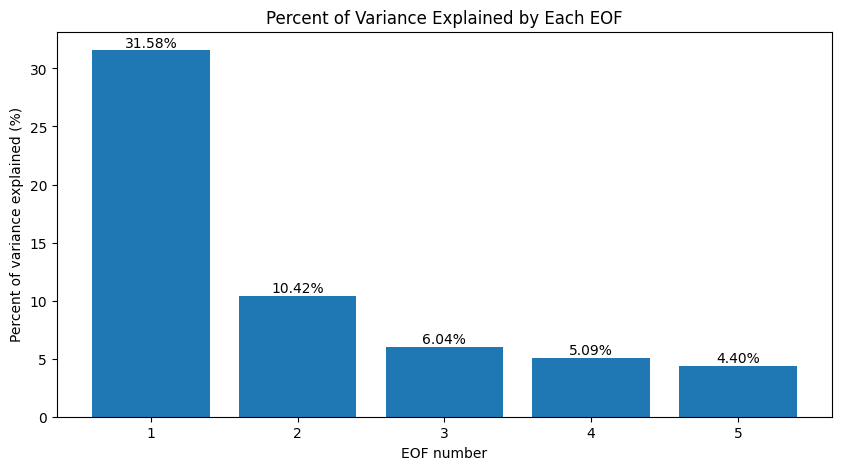

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'eofs' has the 'varianceFraction' attribute
variance_fraction = eofs.attrs['varianceFraction']
eof_numbers = np.arange(1, len(variance_fraction) + 1)

# Plotting
plt.figure(figsize=(10, 5))
bars = plt.bar(eof_numbers, variance_fraction * 100)  # Convert to percentage

# Annotating bars with the percentage of variance explained
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

plt.xlabel('EOF number')
plt.ylabel('Percent of variance explained (%)')
plt.title('Percent of Variance Explained by Each EOF')
plt.xticks(eof_numbers)
plt.show()


Following code computes the Pearson correlation and regression coefficients between the first five principal components (PCs) and detrended, deseasonalized sea surface temperature (SST) anomalies for December-January-February (DJF). Each xr.corr line calculates the correlation for one PC against the SST anomalies, indicating how well the temporal pattern of each EOF matches with the SST anomalies over time. The xr.cov attempts a regression calculation [computing a scaled measure of covariance (effectively a regression coefficient) between each PC and the SST anomalies]

In [85]:
# Correlation & Regression
cor1 = xr.corr(pcs[0,:], anomalies_DJF, dim="time")
cor2 = xr.corr(pcs[1,:], anomalies_DJF, dim="time")
cor3 = xr.corr(pcs[2,:], anomalies_DJF, dim="time")
cor4 = xr.corr(pcs[3,:], anomalies_DJF, dim="time")
cor5 = xr.corr(pcs[4,:], anomalies_DJF, dim="time")

eg1 = xr.cov(pcs[0,:], anomalies_DJF, dim="time")/pcs[0,:].var(dim='time',skipna=True).values
eg2 = xr.cov(pcs[1,:], anomalies_DJF, dim="time")/pcs[0,:].var(dim='time',skipna=True).values
eg3 = xr.cov(pcs[2,:], anomalies_DJF, dim="time")/pcs[0,:].var(dim='time',skipna=True).values
eg4 = xr.cov(pcs[3,:], anomalies_DJF, dim="time")/pcs[0,:].var(dim='time',skipna=True).values
eg5 = xr.cov(pcs[4,:], anomalies_DJF, dim="time")/pcs[0,:].var(dim='time',skipna=True).values

In [86]:
pip install geocat-comp geocat-viz

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [87]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt

# import geocat.datafiles as gdf
import geocat.viz as gv
import cmaps

In [103]:
# -- figure plot

def makefig(dat, ieof, grid_space):
  # Fix the artifact of not-shown-data around 0 and 360-degree longitudes
  # Generate axes using Cartopy to draw coastlines
  ax = fig.add_subplot(grid_space,
          projection=ccrs.PlateCarree(central_longitude=180))
#          projection=ccrs.Robinson(central_longitude=210))
  ax.coastlines(linewidth=0.5, alpha=0.6)
  
  gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  draw_labels=True,
                  dms=False,
                  x_inline=False,
                  y_inline=False,
                  linewidth=1,
                  linestyle='dotted',
                  color="black",
                  alpha=0.3)
  gl.top_labels = False
  gl.right_labels = False
  gl.rotate_labels = False

  # Use geocat.viz.util convenience function to add minor and major tick lines
  gvutil.add_major_minor_ticks(ax, labelsize=10)
  
  # Use geocat.viz.util convenience function to make latitude, longitude tick labels
  gvutil.add_lat_lon_ticklabels(ax)

  # newcmp = plt.get_cmap('cividis')

    # Define dictionary for kwargs
  kwargs = dict(
    vmin = -0.06,
    vmax = 0.06,
    levels = 21,
    #colors=color_list,
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
  )
  
  # Contouf-plot U data (for filled contours)
  # fillplot = dat[ieof,:,:].plot.contourf(ax=ax,  **kwargs)
  fillplot = dat[ieof,:,:].plot.contourf(ax=ax, cmap='coolwarm', **kwargs)


  # Draw map features on top of filled contour
  ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
  ax.add_feature(cfeature.COASTLINE, edgecolor='gray', linewidth=0.5, zorder=1)
  
  # Use geocat.viz.util convenience function to add titles to left and right of the plot axis.
  gvutil.set_titles_and_labels(ax,
                             lefttitle=f'EOF{ieof+1} pattern',
                             lefttitlefontsize=12,
                             righttitle='',
                             righttitlefontsize=12,
                             maintitle='',
                             xlabel="",
                             ylabel="")

  return ax, fillplot




def make_bar_plot(dataset, ieof, grid_space):
    years = list(dataset.time.dt.year)
    values = list(dataset[ieof,:].values)
    colors = ['blue' if val < 0 else 'red' for val in values]

    ax = fig.add_subplot(grid_space)

    ax.bar(years,
           values,
           color=colors,
           width=1.0,
           edgecolor='black',
           linewidth=0.5)

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gvutil.add_major_minor_ticks(ax,
                                 x_minor_per_major=5,
                                 y_minor_per_major=5,
                                 labelsize=10)

    # Use geocat.viz.util convenience function to set axes tick values
    gvutil.set_axes_limits_and_ticks(ax,
                                     xticks=np.linspace(1980, 2020, 5),
                                     xlim=[1979.5, 2020.5],
                                     ylim=[-3.0, 3.5])

    pct = dataset.attrs['varianceFraction'].values[ieof] * 100
    print(pct)
    gvutil.set_titles_and_labels(ax,
                             lefttitle=f'PC{ieof+1} (normalized)',
                             lefttitlefontsize=12,
                             righttitle=f'{pct:.1f}%',
                             righttitlefontsize=12,
                             xlabel="Year",
                             ylabel="",
                             labelfontsize=10 )
    return ax

Accessing grid location: GridSpec(4, 5)[0:2, 0:1]
31.581691658477624
10.417254442801049
6.04102453833905
5.087252126425076
4.4025641899915895


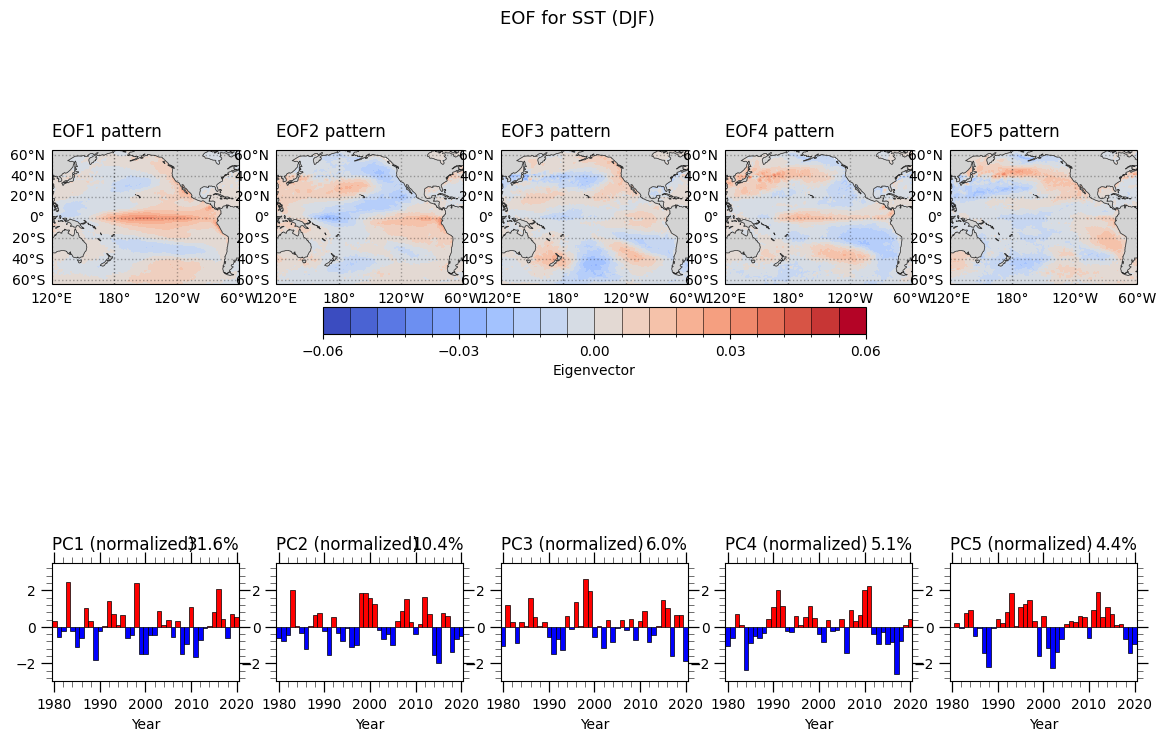

In [104]:
# Show the plot
fig = plt.figure(figsize=(14, 8))  
grid_new = fig.add_gridspec(ncols=5, nrows=4, hspace=0.4)

# Create the EOF plots (assuming each spans 2 rows)
print("Accessing grid location:", grid_new[0:2, 0]) 
ax1, fill1 = makefig(evec, 0, grid_new[0:2, 0])
ax2, fill2 = makefig(evec, 1, grid_new[0:2, 1])
ax3, fill3 = makefig(evec, 2, grid_new[0:2, 2])
ax4, fill4 = makefig(evec, 3, grid_new[0:2, 3])
ax5, fill5 = makefig(evec, 4, grid_new[0:2, 4])

# Create the bar charts in the bottom row
ax6 = make_bar_plot(pcs, 0, grid_new[3, 0])
ax7 = make_bar_plot(pcs, 1, grid_new[3, 1])
ax8 = make_bar_plot(pcs, 2, grid_new[3, 2])
ax9 = make_bar_plot(pcs, 3, grid_new[3, 3])
ax10 = make_bar_plot(pcs, 4, grid_new[3, 4])

# Add the colorbar 
fig.colorbar(fill2, 
             ax=[ax1, ax2, ax3, ax4, ax5],
             ticks=np.linspace(-0.06, 0.06, 5),
             drawedges=True,
             label='Eigenvector',
             orientation='horizontal',
             shrink=0.5,  
             pad=0.08,
             extendfrac='auto',
             extendrect=True)

fig.suptitle('EOF for SST (DJF)', fontsize=13, y=0.95) 
plt.show()  

The top row of maps illustrates the spatial patterns for the first five EOFs of sea surface temperature anomalies. These patterns highlight regions where variations in temperature are most coherent and contribute significantly to the overall variance in the dataset.The colors indicate the magnitude and sign of the anomaly, with red indicating positive anomalies (warmer than average) and blue indicating negative anomalies (cooler than average). The stronger the red or blue color, the larger the anomaly.

The bottom row shows the Principal Component time series for each EOF, which represent the temporal variability corresponding to each spatial pattern. The bars indicate the magnitude and sign of the PC for each year, with red representing positive values and blue indicating negative values.

The percentages in the PC time series titles (e.g., 31.6% for PC1) represent the proportion of the total variance in the dataset that is explained by that particular EOF mode.

Here are some specific observations about the EOF patterns in the image:

EOF1 pattern shows a warming trend in the Pacific Ocean, with the strongest warming in the eastern equatorial Pacific.
EOF2 pattern shows a warming trend in the Atlantic Ocean, with the strongest warming in the tropical North Atlantic.
EOF3 pattern shows a cooling trend in the Indian Ocean, with the strongest cooling in the southeastern Indian Ocean.
EOF4 pattern shows a warming trend in the Southern Ocean, with the strongest warming in the Atlantic sector.
EOF5 pattern shows a dipole pattern in the Pacific Ocean, with warming in the western tropical Pacific and cooling in the eastern tropical Pacific.

These patterns are consistent with the observed patterns of sea surface temperature variability in the recent decades. For example, the warming trend in the Pacific Ocean is associated with El Niño-Southern Oscillation (ENSO), while the warming trend in the Atlantic Ocean is associated with the Atlantic Multidecadal Oscillation (AMO)

Plot the percent of variance explained by the first 10 EOFs.

In [90]:
# Specify the number of EOFs (modes) you want to calculate
neof_new= 10

# Calculate the EOFs specifying you want 10 of them
eofs_new = eofunc_eofs(xw_anm.data, neofs=neof_new, meta=True)
pcs_new = eofunc_pcs(xw_anm.data, npcs=neof_new, meta=True)


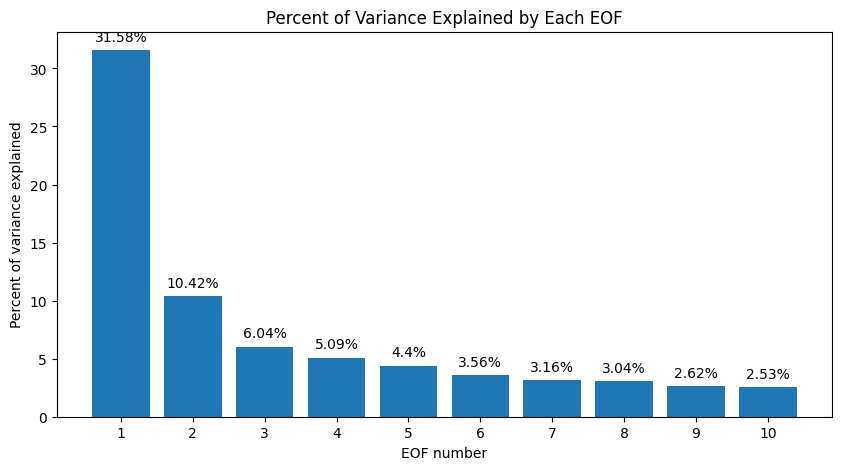

In [91]:
import matplotlib.pyplot as plt

# Assuming `eofs` is your EOF result and contains an attribute `varianceFraction`
variance_fraction_new = eofs_new.attrs['varianceFraction'][:10]  # Get the variance fraction for the first 10 EOFs

# Generate a range of EOF numbers for plotting (1-based indexing for display)
eof_numbers_new = range(1, 11)

# Plotting
plt.figure(figsize=(10, 5))
bars = plt.bar(eof_numbers_new, variance_fraction_new * 100)  # Convert to percentage

# Annotate the percentage on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{round(yval, 2)}%", ha='center', va='bottom')

plt.xlabel('EOF number')
plt.ylabel('Percent of variance explained')
plt.title('Percent of Variance Explained by Each EOF')
plt.xticks(eof_numbers_new)  # Set x-tick labels to correspond to EOF numbers
plt.show()


Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient (xarray.corr) of the reconstructed monthly time series and the "observed" SST time series.

In [105]:
# Reconstruct the SST field using the first 5 EOFs
#Loading our EOFs (spatial patterns), lat (dim_1): 130 and lon (dim_2): 181
eofs

<xarray.DataArray 'eofs' (eof: 5, dim_1: 130, dim_2: 181)> Size: 941kB
array([[[ 1.51637544e-03,  1.15762515e-03,  1.00001140e-03, ...,
         -7.83256659e-04, -7.36844106e-04,             nan],
        [ 1.64971240e-03,  1.21515885e-03,  1.05703943e-03, ...,
         -1.74912830e-03, -1.23590984e-03, -1.41336577e-03],
        [ 1.37645143e-03,  1.57687479e-03,  1.55174705e-03, ...,
         -2.78455174e-03, -2.28174649e-03, -1.90013706e-03],
        ...,
        [            nan,             nan,             nan, ...,
         -2.24519128e-04, -9.02225327e-04, -1.32720956e-03],
        [            nan,             nan,             nan, ...,
         -4.29145228e-05, -2.18144750e-04, -8.71324379e-04],
        [            nan,             nan,             nan, ...,
         -2.49217199e-06, -4.60328530e-05, -1.96267552e-04]],

       [[-1.31008939e-03, -1.32717388e-03, -1.25809195e-03, ...,
         -7.58704601e-04, -7.24130349e-04,             nan],
        [-7.07585605e-05, -7.51947806e-04, -3.25564674e-04, ...,
          1.26654313e-03,  6.22829221e-04, -6.99895800e-04],
        [-4.66907726e-04, -4.68729184e-04, -8.05248689e-04, ...,
          8.44772932e-04,  1.11940615e-03,  7.97675372e-04],
...
        [            nan,             nan,             nan, ...,
          4.71003327e-04,  2.67966876e-03,  8.29501296e-03],
        [            nan,             nan,             nan, ...,
          1.17121860e-04,  6.23818540e-04,  2.36410051e-03],
        [            nan,             nan,             nan, ...,
          5.28937831e-06,  1.54908563e-04,  6.57501955e-04]],

       [[ 5.68862415e-04,  3.71966824e-04,  3.57971382e-04, ...,
          2.54686249e-03,  1.72718577e-03,             nan],
        [-8.08418091e-04, -9.00882204e-04, -5.32481251e-04, ...,
          4.24722413e-04,  6.93461989e-04,  1.09974117e-03],
        [-2.69652603e-03, -2.08890990e-03, -1.41846688e-03, ...,
          1.55030191e-03,  1.05759434e-03,  8.93159158e-04],
        ...,
        [            nan,             nan,             nan, ...,
          2.81984909e-05, -2.33471488e-03, -1.06225556e-02],
        [            nan,             nan,             nan, ...,
          2.56641160e-05,  1.28709884e-04, -1.23470447e-03],
        [            nan,             nan,             nan, ...,
          1.78630414e-06,  5.24620948e-05,  1.25099059e-04]]])
Dimensions without coordinates: eof, dim_1, dim_2
Attributes:
    eigenvalues:           <xarray.DataArray 'eigenvalues' (mode: 5)> Size: 4...
    northTest:             <xarray.DataArray 'typical_errors' (mode: 5)> Size...
    totalAnomalyVariance:  5379.244414306211
    varianceFraction:      <xarray.DataArray 'variance_fractions' (mode: 5)> ...

In [106]:
# Loading the corresponding principal components (time series)
pcs

<xarray.DataArray 'pcs' (pc: 5, time: 43)> Size: 2kB
array([[-0.21278226,  0.33146598, -0.56562157, -0.23803543,  2.43816408,
        -0.23183891, -1.1123813 , -0.6099727 ,  1.04522181,  0.29515714,
        -1.79733321, -0.24311599,  0.03960112,  1.40144063,  0.70199572,
         0.12081062,  0.64949678, -0.5959039 , -0.45576841,  2.40796761,
        -1.51646396, -1.47691768, -0.46689311, -0.4263541 ,  0.88786962,
         0.11953226,  0.36819589, -0.58388142,  0.34427463, -1.51556813,
        -0.95142162,  1.09858851, -1.65723142, -0.70754991, -0.07869547,
         0.04352743,  0.82366396,  2.08469925,  0.44612605, -0.61513571,
         0.72841988,  0.55197387, -0.86932663],
       [-0.3052001 , -0.60516225, -0.78128601, -0.44464865,  2.00122384,
         0.06961563, -0.32313184, -1.19941949,  0.03548049,  0.64982458,
         0.77137117, -0.24279827, -1.56715472,  0.54838823, -0.31971193,
        -0.79105992, -0.08866033, -1.12520968, -1.01732221,  1.84285139,
         1.84176117,  1.59747303,  1.26866267, -0.17291325, -0.69254223,
        -0.40574313, -0.99586844,  0.31652985,  0.85054582,  1.53012566,
         0.2856339 , -0.41034694,  0.15070201,  1.66017276,  0.69278949,
        -1.56722268, -2.0125836 ,  0.73469957,  0.58290339, -1.3626823 ,
        -0.68443066, -0.51701062,  0.20135461],
       [-1.78904133, -1.06341417,  1.17304482,  0.26092728, -0.89241602,
         0.26022187,  0.04885865,  1.60227343,  0.55306338,  0.02452907,
...
         0.06745686,  1.47613534,  1.02304162, -1.59894267,  0.65555659,
         0.64316713, -1.89049904, -0.7424633 ],
       [ 0.44229191, -1.06790219, -0.63204877,  0.68385741,  0.09435848,
        -2.38890289, -0.91479078, -0.52452327, -0.59298016, -0.31533369,
         0.43983255,  1.07434761,  2.0423174 ,  1.16573226, -0.22090157,
        -0.30955624,  0.60928417,  0.08559457,  0.54018254,  1.13842188,
         0.50795996, -0.38485909, -0.82255323,  0.3501295 , -0.22157913,
        -0.17397087,  0.45460307, -1.43768764,  0.92520718,  0.29357729,
         0.6270133 ,  2.00595877,  2.22689929, -0.37971099, -0.96973672,
        -0.31109354, -0.94239487, -0.81186497, -2.60347989, -0.77437672,
         0.07315517,  0.4063712 ,  0.61315172],
       [-1.24541196, -0.00525936,  0.22065923, -0.0810954 ,  0.7637297 ,
         0.90079649, -0.48731966, -0.07165407, -1.44357695, -2.18292915,
        -0.04118758,  0.42792066,  0.21066844,  0.80766   ,  1.85623044,
         0.04842895,  1.06751393,  1.23960599,  1.47612903,  0.30972342,
        -1.60651998,  0.57958232, -1.1825203 , -2.2865885 , -1.35783964,
        -0.69433329,  0.13965413,  0.31586883,  0.26223312,  0.61055001,
         0.52006076, -0.60998721,  0.90965628,  1.89578977,  0.55020775,
         1.07720985,  0.72887596,  0.11712899,  0.13380381, -0.64910831,
        -1.45466212, -0.92394985, -0.84574454]])
Coordinates:
  * time     (time) datetime64[ns] 344B 1979-02-15 ... 2021-02-15
    reftime  (time) datetime64[ns] 344B 1979-02-01 1980-02-01 ... 2021-02-01
    month    (time) int64 344B 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2
Dimensions without coordinates: pc
Attributes:
    varianceFraction:  <xarray.DataArray 'variance_fractions' (mode: 5)> Size...

In [108]:

eofs_5 = eofs.isel(eof=slice(0, 5))
pcs_5 = pcs.isel(pc=slice(0, 5)) 

# Matrix multiplication for reconstruction 
# (xarray takes care of aligning dimensions)
sst_reconstructed = xr.dot(eofs_5, pcs_5) 

In [109]:
sst_reconstructed

<xarray.DataArray (eof: 5, dim_1: 130, dim_2: 181, pc: 5, time: 43)> Size: 202MB
array([[[[[-3.22657794e-04,  5.02626873e-04, -8.57694662e-04, ...,
            1.10455802e-03,  8.36999612e-04, -1.31822555e-03],
          [-4.62797936e-04, -9.17653173e-04, -1.18472291e-03, ...,
           -1.03785383e-03, -7.83982202e-04,  3.05329187e-04],
          [-2.71285833e-03, -1.61253512e-03,  1.77877635e-03, ...,
            9.75282840e-04, -2.86670631e-03, -1.12585311e-03],
          [ 6.70680590e-04, -1.61934065e-03, -9.58423227e-04, ...,
            1.10930706e-04,  6.16211307e-04,  9.29768202e-04],
          [-1.88851211e-03, -7.97516623e-06,  3.34602239e-04, ...,
           -2.20581391e-03, -1.40105485e-03, -1.28246625e-03]],

         [[-2.46322097e-04,  3.83713357e-04, -6.54777760e-04, ...,
            8.43237176e-04,  6.38978829e-04, -1.00635437e-03],
          [-3.53307312e-04, -7.00551042e-04, -9.04436333e-04, ...,
           -7.92314140e-04, -5.98504494e-04,  2.33093162e-04],
          [-2.07103924e-03, -1.23103498e-03,  1.35794618e-03, ...,
            7.44546447e-04, -2.18848923e-03, -8.59494188e-04],
          [ 5.12008240e-04, -1.23623043e-03, -7.31675550e-04, ...,
            8.46862670e-05,  4.70425522e-04,  7.09799848e-04],
          [-1.44172021e-03, -6.08836886e-06,  2.55440676e-04, ...,
...
            3.82144330e-05,  2.89577053e-05, -4.56066963e-05],
          [-1.60114366e-05, -3.17480794e-05, -4.09879007e-05, ...,
           -3.59066660e-05, -2.71234601e-05,  1.05634847e-05],
          [-9.38568558e-05, -5.57889349e-05,  6.15403884e-05, ...,
            3.37418950e-05, -9.91795399e-05, -3.89511800e-05],
          [ 2.32035602e-05, -5.60243859e-05, -3.31586024e-05, ...,
            3.83787357e-06,  2.13190845e-05,  3.21672235e-05],
          [-6.53369206e-05, -2.75917109e-07,  1.15762455e-05, ...,
           -7.63146221e-05, -4.84723445e-05, -4.43695305e-05]],

         [[-2.66188606e-05,  4.14660824e-05, -7.07587266e-05, ...,
            9.11246419e-05,  6.90514112e-05, -1.08751944e-04],
          [-3.81802454e-05, -7.57052281e-05, -9.77381445e-05, ...,
           -8.56216309e-05, -6.46775417e-05,  2.51892724e-05],
          [-2.23807387e-04, -1.33032112e-04,  1.46746803e-04, ...,
            8.04596029e-05, -2.36499651e-04, -9.28814600e-05],
          [ 5.53303018e-05, -1.33593559e-04, -7.90687061e-05, ...,
            9.15164318e-06,  5.08366548e-05,  7.67047027e-05],
          [-1.55799865e-04, -6.57941144e-07,  2.76042622e-05, ...,
           -1.81976862e-04, -1.15585256e-04, -1.05801847e-04]]]]])
Coordinates:
  * time     (time) datetime64[ns] 344B 1979-02-15 ... 2021-02-15
    reftime  (time) datetime64[ns] 344B 1979-02-01 1980-02-01 ... 2021-02-01
    month    (time) int64 344B 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2
Dimensions without coordinates: eof, dim_1, dim_2, pc

In [110]:
# Renaming the dimensions in the reconstructed SST DataArray
sst_reconstructed = sst_reconstructed.rename({'dim_1': 'lat', 'dim_2': 'lon'})

# Since 'eofs' has the desired coordinates, inheriting them
sst_reconstructed = sst_reconstructed.assign_coords(coords=eofs.coords) 

print(sst_reconstructed)


<xarray.DataArray (eof: 5, lat: 130, lon: 181, pc: 5, time: 43)> Size: 202MB
array([[[[[-3.22657794e-04,  5.02626873e-04, -8.57694662e-04, ...,
            1.10455802e-03,  8.36999612e-04, -1.31822555e-03],
          [-4.62797936e-04, -9.17653173e-04, -1.18472291e-03, ...,
           -1.03785383e-03, -7.83982202e-04,  3.05329187e-04],
          [-2.71285833e-03, -1.61253512e-03,  1.77877635e-03, ...,
            9.75282840e-04, -2.86670631e-03, -1.12585311e-03],
          [ 6.70680590e-04, -1.61934065e-03, -9.58423227e-04, ...,
            1.10930706e-04,  6.16211307e-04,  9.29768202e-04],
          [-1.88851211e-03, -7.97516623e-06,  3.34602239e-04, ...,
           -2.20581391e-03, -1.40105485e-03, -1.28246625e-03]],

         [[-2.46322097e-04,  3.83713357e-04, -6.54777760e-04, ...,
            8.43237176e-04,  6.38978829e-04, -1.00635437e-03],
          [-3.53307312e-04, -7.00551042e-04, -9.04436333e-04, ...,
           -7.92314140e-04, -5.98504494e-04,  2.33093162e-04],
          [

In [111]:
#Loading Observed SST
anomalies_DJF

<xarray.DataArray (time: 43, lat: 130, lon: 181)> Size: 8MB
array([[[-6.03287946e-01, -5.90474353e-01, -5.93044668e-01, ...,
          6.11980118e-01,  4.04428347e-01,             nan],
        [-5.96556818e-01, -6.04397704e-01, -6.25023407e-01, ...,
         -1.15948266e-01, -2.42757666e-02,  6.93248815e-01],
        [-2.75343555e-01, -4.77457805e-01, -4.26833699e-01, ...,
         -4.47919987e-01, -4.28104634e-01, -3.14900688e-01],
        ...,
        [            nan,             nan,             nan, ...,
          3.10267916e-02,  4.30492945e-01,  1.09704521e+00],
        [            nan,             nan,             nan, ...,
         -4.82346786e-04,  2.19044044e-03,  2.73316732e-01],
        [            nan,             nan,             nan, ...,
          4.93723182e-05,  4.61203781e-04, -1.36428720e-03]],

       [[ 1.70294861e-01,  1.48660970e-01,  1.58545988e-01, ...,
          4.22324911e-01,  4.27749088e-01,             nan],
        [-1.23625980e-01, -1.18792204e-01, -6.84396122e-02, ...,
         -1.27933661e-01, -1.00838526e-01, -2.61071920e-01],
        [-2.42998319e-01, -1.15933468e-01, -1.75455580e-01, ...,
         -3.08366996e-01, -3.70034917e-01, -2.98077957e-01],
...
        [            nan,             nan,             nan, ...,
         -3.15497153e-02, -6.29292910e-02,  7.84861471e-01],
        [            nan,             nan,             nan, ...,
         -3.63130715e-03, -2.41736038e-02, -4.01153924e-02],
        [            nan,             nan,             nan, ...,
         -3.24506275e-04, -4.79593366e-03, -2.47249530e-02]],

       [[-4.86894582e-01, -3.62247537e-01, -2.80136555e-01, ...,
          6.58924522e-02,  1.19518313e-01,             nan],
        [-2.13829193e-01, -2.44346751e-01, -1.86528433e-01, ...,
          3.86805881e-02, -2.34678989e-02, -2.64165029e-01],
        [-5.98653164e-02, -6.83933258e-02, -1.28563534e-01, ...,
         -1.58190358e-01, -7.03037064e-02,  8.08784678e-03],
        ...,
        [            nan,             nan,             nan, ...,
         -1.94499834e-02,  5.70937479e-02,  4.64820783e-01],
        [            nan,             nan,             nan, ...,
         -3.29331640e-03, -1.53986385e-02,  8.99437111e-02],
        [            nan,             nan,             nan, ...,
          8.12145263e-05, -4.50939618e-03, -2.35702318e-02]]])
Coordinates:
  * lat      (lat) float32 520B -64.25 -63.25 -62.25 ... 62.75 63.75 64.75
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time     (time) datetime64[ns] 344B 1979-02-15 ... 2021-02-15
    reftime  (time) datetime64[ns] 344B 1979-02-01 1980-02-01 ... 2021-02-01
    month    (time) int64 344B 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2
Attributes:
    long_name:  Sea Surface Temperature Anomalies

In [112]:
# Ensuring time dimensions are aligned 
if not sst_reconstructed.time.equals(anomalies_DJF.time):
    raise ValueError("Time dimensions must match for correlation.") 

In [116]:
# Collapsing the 'eof' and 'pc' dimensions if they're still present after reconstruction
sst_reconstructed = sst_reconstructed.mean(dim=['eof', 'pc'])

# Now calculating the correlation coefficient at each grid point
correlation_map = xr.corr(sst_reconstructed, anomalies_DJF, dim='time')

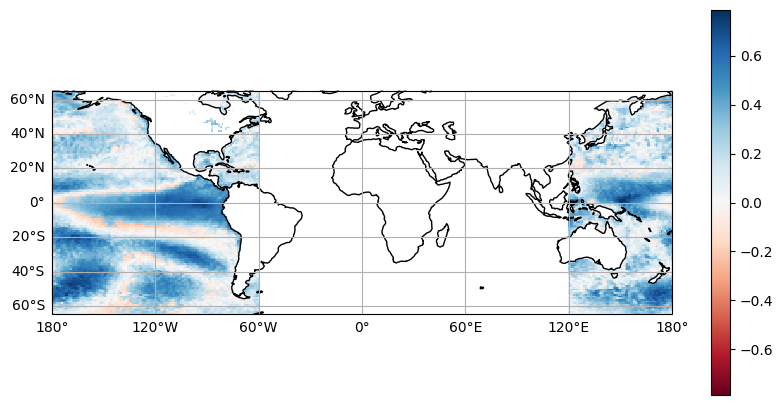

In [118]:
import cartopy.feature as cfeature

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10, 5))

# Plotting the data
correlation_map.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', add_colorbar=True)

# Adding coastlines for better reference
ax.coastlines()

# Adding gridlines with labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.show()


Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean water vapour anomalies (don't mask these over land for the plot). See anything interesting?

In [122]:
# Assuming 'tcwv' is the variable name water vapur in our dataset
tcwv = ds['Total_column_water_vapour_surface_Mixed_intervals_Average']

climatology_preci = tcwv.groupby('time.month').mean('time')
anomalies_preci = tcwv.groupby('time.month') - climatology_preci

In [123]:
anomalies_preci

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               lat: 130,
                                                                               lon: 181)> Size: 49MB
array([[[-0.84616494, -0.78000855, -0.7082652 , ...,  1.3655219 ,
          1.4234116 ,  1.4801431 ],
        [-0.9114584 , -0.8559532 , -0.7970643 , ...,  1.3566873 ,
          1.4274766 ,  1.4940195 ],
        [-0.9383706 , -0.87176   , -0.8120079 , ...,  1.4002695 ,
          1.4743066 ,  1.53181   ],
        ...,
        [-1.0893517 , -1.1195116 , -1.1979094 , ...,  0.8411083 ,
          0.7272587 ,  0.5954008 ],
        [-1.202838  , -1.2145567 , -1.2044277 , ...,  0.54123497,
          0.42132282,  0.27924442],
        [-1.1670227 , -1.1710205 , -1.15837   , ...,  0.5177746 ,
          0.35884523,  0.25274086]],

       [[-0.6710856 , -0.6402445 , -0.60458875, ...,  0.733279  ,
          0.89888597,  1.0363994 ],
        [-0.61094785, -0.58705616, -0.5637548 , ...,  0.88616776,
          1.1147063 ,  1.3690214 ],
        [-0.5031626 , -0.48756027, -0.476977  , ...,  1.1525877 ,
          1.469244  ,  1.7221739 ],
...
        [-1.2091408 , -1.1922212 , -1.1621976 , ...,  0.41767693,
          0.41286135,  0.41338396],
        [-1.1773229 , -1.1702371 , -1.1587677 , ...,  0.59929466,
          0.6074481 ,  0.5325246 ],
        [-1.1311965 , -1.130084  , -1.0917253 , ...,  0.6558666 ,
          0.4122715 ,  0.17950916]],

       [[-0.42648733, -0.42596495, -0.4161085 , ...,  1.0607941 ,
          1.124157  ,  1.2514281 ],
        [-0.43997753, -0.45378578, -0.45660174, ...,  0.95196414,
          1.0364478 ,  1.1419847 ],
        [-0.42675984, -0.42905366, -0.43177903, ...,  0.87436104,
          0.9760599 ,  1.0469623 ],
        ...,
        [ 0.6105995 ,  0.6500931 ,  0.63957787, ...,  0.34633732,
          0.35433197,  0.36339378],
        [ 0.6699877 ,  0.5299082 ,  0.346632  , ...,  0.37143326,
          0.34779072,  0.302392  ],
        [ 0.05155087, -0.11936998, -0.30548477, ...,  0.4694972 ,
          0.34628963,  0.13480806]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time     (time) datetime64[ns] 4kB 1979-01-16T12:00:00 ... 2021-12-16T12:...
    reftime  (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [148]:
eofs_1 = eofs.isel(eof=0)  # Select the first EOF
pcs_1 = pcs.isel(pc=0)      # Select the corresponding first PC

# Matrix multiplication for reconstruction 
# (xarray takes care of aligning dimensions)

sst_reconstructed_eof1 = xr.dot(eofs_1, pcs_1) 

# Rename the dimensions in the reconstructed SST DataArray

sst_reconstructed_eof1 = sst_reconstructed_eof1.rename({'dim_1': 'lat', 'dim_2': 'lon'})

# Since 'eofs' has the desired coordinates, inherit them

sst_reconstructed_eof1 = sst_reconstructed_eof1.assign_coords(coords=eofs.coords) 

print(sst_reconstructed_eof1)

<xarray.DataArray (lat: 130, lon: 181, time: 43)> Size: 8MB
array([[[-3.22657794e-04,  5.02626873e-04, -8.57694662e-04, ...,
          1.10455802e-03,  8.36999612e-04, -1.31822555e-03],
        [-2.46322097e-04,  3.83713357e-04, -6.54777760e-04, ...,
          8.43237176e-04,  6.38978829e-04, -1.00635437e-03],
        [-2.12784688e-04,  3.31469762e-04, -5.65628024e-04, ...,
          7.28428190e-04,  5.51980160e-04, -8.69336547e-04],
        ...,
        [ 1.66663123e-04, -2.59622937e-04,  4.43026864e-04, ...,
         -5.70539724e-04, -4.32337206e-04,  6.80905874e-04],
        [ 1.56787355e-04, -2.44238755e-04,  4.16774923e-04, ...,
         -5.36731897e-04, -4.06718689e-04,  6.40558206e-04],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-3.51029535e-04,  5.46823541e-04, -9.33112925e-04, ...,
          1.20168331e-03,  9.10598131e-04, -1.43413893e-03],
        [-2.58564247e-04,  4.02783821e-04, 

In [147]:
# Resample EOF1 to monthly frequency (as we have yearly data)
sst_eof1_monthly = sst_reconstructed_eof1.resample(time='MS').mean()  
sst_eof1_monthly

<xarray.DataArray (lat: 130, lon: 181, time: 505)> Size: 95MB
array([[[-3.22657794e-04,             nan,             nan, ...,
                     nan,             nan, -1.31822555e-03],
        [-2.46322097e-04,             nan,             nan, ...,
                     nan,             nan, -1.00635437e-03],
        [-2.12784688e-04,             nan,             nan, ...,
                     nan,             nan, -8.69336547e-04],
        ...,
        [ 1.66663123e-04,             nan,             nan, ...,
                     nan,             nan,  6.80905874e-04],
        [ 1.56787355e-04,             nan,             nan, ...,
                     nan,             nan,  6.40558206e-04],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-3.51029535e-04,             nan,             nan, ...,
                     nan,             nan, -1.43413893e-03],
        [-2.58564247e-04,             nan,             nan, ...,
                     nan,             nan, -1.05636995e-03],
        [-2.24919241e-04,             nan,             nan, ...,
                     nan,             nan, -9.18912533e-04],
...
        [ 9.13144918e-06,             nan,             nan, ...,
                     nan,             nan,  3.73067376e-05],
        [ 4.64173330e-05,             nan,             nan, ...,
                     nan,             nan,  1.89639041e-04],
        [ 1.85402371e-04,             nan,             nan, ...,
                     nan,             nan,  7.57465489e-04]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 5.30289991e-07,             nan,             nan, ...,
                     nan,             nan,  2.16651149e-06],
        [ 9.79497454e-06,             nan,             nan, ...,
                     nan,             nan,  4.00175851e-05],
        [ 4.17622534e-05,             nan,             nan, ...,
                     nan,             nan,  1.70620610e-04]]])
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-02-01 1979-03-01 ... 2021-02-01
Dimensions without coordinates: lat, lon

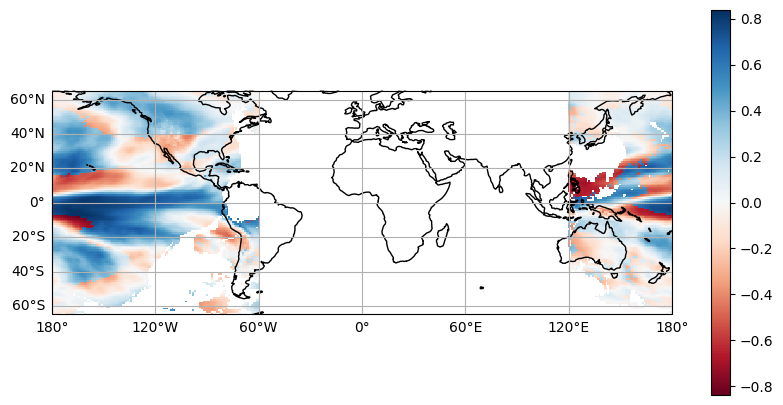

In [155]:
# Let's assume sst_reconstructed_eof1 and anomalies_preci are your two xarray DataArrays or Datasets

# Align the two datasets to only the time points they have in common
sst_reconstructed_eof1_aligned, anomalies_preci_aligned = xr.align(
    sst_reconstructed_eof1, anomalies_preci, join='inner', copy=True
)

# Ensure that the 'time' coordinates match exactly after alignment
assert sst_reconstructed_eof1_aligned.time.equals(anomalies_preci_aligned.time)

# Now, compute the correlation
# Assuming these are DataArrays, if they are Datasets you would need to specify which variables to correlate
correlation = xr.corr(sst_reconstructed_eof1_aligned, anomalies_preci_aligned, dim='time')

import cartopy.feature as cfeature

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10, 5))

# Plot the data
correlation.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', add_colorbar=True)

# Add coastlines for better reference
ax.coastlines()

# Add gridlines with labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.show()

Areas with Strong Positive Correlation (Blue Tones): Regions in blue indicate where the first EOF of SST (SST EOF1) has a positive correlation with the monthly mean water vapor anomalies. In these regions, when the SST EOF1 is in a phase associated with higher temperatures, there tends to be more water vapor. This suggests that in these areas, increased sea surface temperatures are associated with increased atmospheric water vapor, which is consistent with the understanding that warmer water leads to more evaporation.

Areas with Strong Negative Correlation (Red Tones): Regions in red show where the SST EOF1 has a negative correlation with water vapor anomalies. In these regions, when the SST EOF1 is in a phase associated with higher temperatures, there tends to be less water vapor. This negative correlation could be indicative of particular ocean-atmosphere interactions, such as where increased sea surface temperatures could be related to atmospheric conditions that reduce humidity, like increased subsidence or the presence of dry air masses.

Regions of No or Weak Correlation (White or Light-Colored Areas): These areas show little to no relationship between SST EOF1 and water vapor anomalies, indicating that the dominant pattern of SST variability captured by the EOF1 may not play a significant role in determining water vapor variability in these regions.

Positive correlations in blue might be found in regions where you'd expect evaporation to increase with temperature, influencing the water cycle. Conversely, negative correlations in red might be unexpected or may point to complex interactions in the climate system that require further investigation to understand.